In [27]:
!git clone "https://github.com/tnagire1/flickr8k_dataset"
#Flikr 8K data set

fatal: destination path 'flickr8k_dataset' already exists and is not an empty directory.


In [28]:
#importing packages
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
from tensorflow.keras.applications import VGG19
from keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
import matplotlib.pyplot as plt
import time
from pylab import *
from tqdm.notebook import tqdm
tqdm().pandas()



0it [00:00, ?it/s]

In [29]:
#Reads the file and extraxts the test.(Generic)
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text



In [30]:
# get all imgs with their captions and keep in a dictionary with image as key
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

In [31]:
##Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lower case
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

In [32]:
def text_vocabulary(descriptions):
    # build vocabulary of all unique words from  dictionary as input
    vocab = set()
    
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    
    return vocab

In [33]:
#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [34]:
#Extracting featuers and converting into gaussian distribution(1) Z score normalization.
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
            
            feature = model.predict(image)
            features[img] = feature
        return features

In [35]:
dataset_text = "/content/flickr8k_dataset/Flicker8k_text"
dataset_images = "/content/flickr8k_dataset/Flicker8k_Dataset"

In [11]:
#Save all features in a file.
features = extract_features(dataset_images)
dump(features, open("/content/features.p","wb"))

  0%|          | 0/8091 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


KeyboardInterrupt: ignored

In [36]:
#we prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file 
save_descriptions(clean_descriptions, "/content/descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


In [37]:
features = load(open("/content/features.p","rb"),allow_pickle=True)

In [38]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos):   
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        
        words = line.split()
        if len(words)<1 :
            continue
    
        image, image_caption = words[0], words[1:]
        
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


def load_features(photos):
    #loading all features
    #changed
    all_features = load(open("features.p","rb"),allow_pickle=True)
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

In [39]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary 

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [40]:
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [41]:
# give each word a index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size 

7577

In [42]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)
max_length

32

In [43]:
features['1000268201_693b08cb0e.jpg'][0]

array([0.4733967 , 0.01732624, 0.07333985, ..., 0.08559044, 0.021023  ,
       0.2376653 ], dtype=float32)

In [44]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]         

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [45]:
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 7577))

In [49]:
from keras.utils.vis_utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):
    
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    se4 = Dense(256, activation='relu')(se3)

    # Merging both models
    decoder1 = Add()([fe2, se4])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    
    return model

In [50]:
define_model(7767,34)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 34)]         0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 34, 256)      1988352     ['input_16[0][0]']               
                                                                                                  
 input_15 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 dropout_13 (Dropout)           (None, 34, 256)      0           ['embedding_6[0][0]']            
                                                                                            

In [52]:
# train our model, skip this as already trained
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

batch=64
model = define_model(vocab_size, max_length)
epochs = 1
steps = len(train_descriptions)//batch
# making a directory models to save our models
os.mkdir("models")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit(generator, epochs=500, steps_per_epoch= steps, verbose=1)
    model.save("content/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 32)]         0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 32, 256)      1939712     ['input_20[0][0]']               
                                                                                                  
 input_19 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 dropout_17 (Dropout)           (None, 32, 256)      0           ['embedding_8[0][0]

FileExistsError: ignored

Testing part

In [ ]:
def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except e:
            raise e
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

In [27]:
def word_for_id(integer, tokenizer):
 for word, index in tokenizer.word_index.items():
     if index == integer:
         return word
 return None

In [28]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

In [30]:
max_length = 32
#changed
tokenizer = np.load("/content/tokenizer.p",allow_pickle=True)
model = load_model('/content/flickr8k_dataset/models/Xception_model/model_3.h5')

In [31]:
testdir="/content/flickr8k_dataset/test_images"
for img in tqdm(os.listdir(testdir)):
  print(img)

  0%|          | 0/19 [00:00<?, ?it/s]

.DS_Store
test_img_14.jpg
test_img_08.jpg
test_img_09.jpg
test_img_19.jpg
test_image_05.jpg
test_img_1.jpg
test_img_07.jpg
test_img_17.jpg
test_img_16.jpg
test_image_06.jpg
test_image_3.jpg
test_img_12.jpg
.DS_Store~merged
test_img_2.jpg
test_img_13.jpg
test_img_11.jpg
test_img_04.jpg
test_img_15.jpg


  0%|          | 0/19 [00:00<?, ?it/s]

1/1 [==============================] - 1s 644ms/step



start man is climbing rock face end


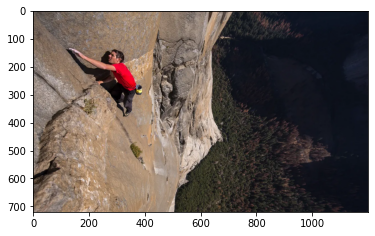

1/1 [==============================] - 1s 636ms/step



start little boy in pink shirt is sitting on the bed end


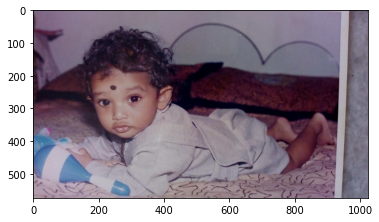

1/1 [==============================] - 1s 648ms/step



start man in red shirt and black pants is sitting on rock end


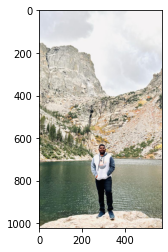

1/1 [==============================] - 1s 620ms/step



start man in red shirt is sitting on the beach end


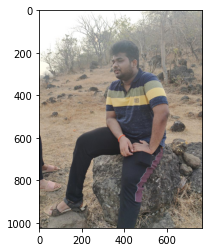

1/1 [==============================] - 1s 918ms/step



start man in red shirt is sitting on the beach end


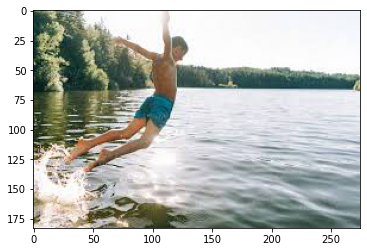

1/1 [==============================] - 1s 628ms/step



start man in black wetsuit is sitting on the beach end


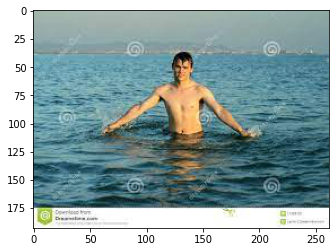

1/1 [==============================] - 1s 659ms/step



start two men are playing soccer end


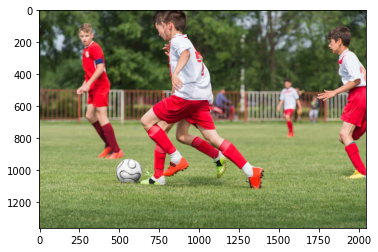

1/1 [==============================] - 1s 625ms/step



start man in red shirt is sitting on bench with his arms end


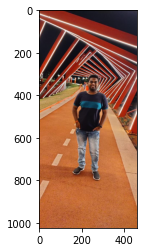

1/1 [==============================] - 1s 608ms/step



start man is climbing rock end


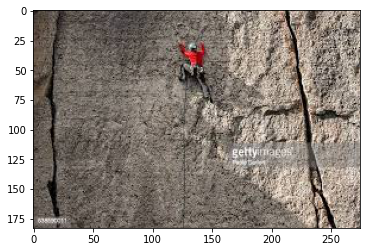

1/1 [==============================] - 1s 636ms/step



start boy in red swimsuit is jumping into the water end


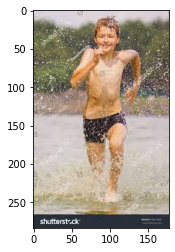

1/1 [==============================] - 1s 629ms/step



start dog runs through the grass end


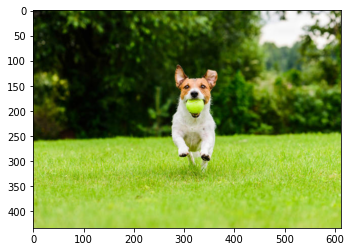

1/1 [==============================] - 1s 633ms/step



start man in red shirt is sitting on the beach end


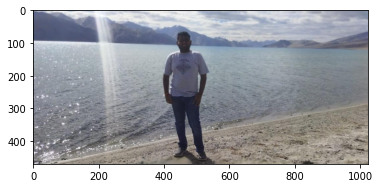

1/1 [==============================] - 1s 620ms/step



start dog is running through the water end


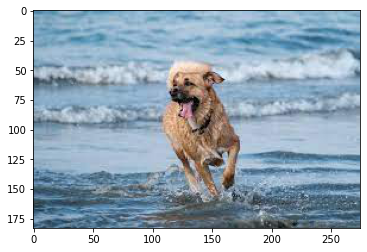

1/1 [==============================] - 1s 633ms/step



start man in red jacket is walking through the snow end


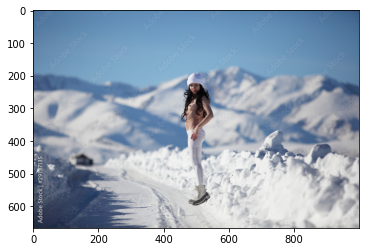

1/1 [==============================] - 1s 637ms/step



start man in red shirt riding bike on the street end


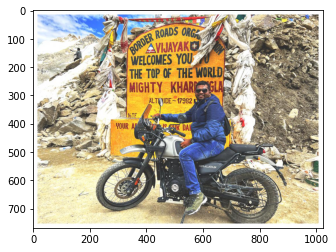

1/1 [==============================] - 1s 626ms/step



start two children are playing in the water end


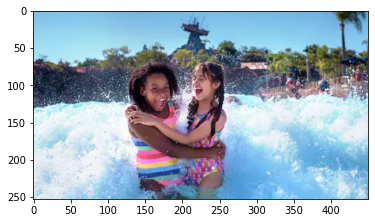

1/1 [==============================] - 1s 641ms/step



start man in red shirt is sitting on the edge of the ocean end


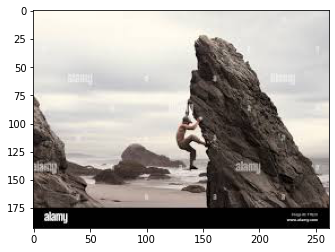

In [38]:
for img in tqdm(os.listdir(testdir)):
  if(img != ".ipynb_checkpoints"):
    img_path=testdir+"/"+img
    xception_model = Xception(include_top=False, pooling="avg")
    photo = extract_features(img_path, xception_model)
    image = Image.open(img_path)
    description = generate_desc(model, tokenizer, photo, max_length)
    print("\n\n")
    print(description)
    imshow(image)
    show()

In [39]:
filename = dataset_text + "/" + "Flickr_8k.testImages.txt"
test_imgs = load_photos(filename)
test_descriptions = load_clean_descriptions("descriptions.txt", test_imgs)
test_features = load_features(test_imgs)

In [40]:
test_output={}
for line in tqdm(open(filename)):
  img_path=dataset_images+"/"+line.split("\t")[0].strip()
  xception_model = Xception(include_top=False, pooling="avg")
  photo = extract_features(img_path, xception_model)
  image = Image.open(img_path.strip())
  description = generate_desc(model, tokenizer, photo, max_length)
  test_output[img_path]=description

0it [00:00, ?it/s]

1/1 [==============================] - 1s 605ms/step


In [41]:
test_out={}
skip=len("/content/flickr8k_dataset/Flicker8k_Dataset/")
skip_start=len("start ")
skip_end=len(" end")
for i in test_output:
  test_out[i[skip:]]=test_output[i][skip_start:-skip_end].split(" ")

In [42]:
skip_start=len("<start> ")
skip_end=len(" <end>")
test_desc={}
for key in test_descriptions:
   test_desc[key]=[]
   for i in test_descriptions[key]:
     test_desc[key].append(i[skip_start:-skip_end].split(" "))

In [43]:
pred=[]
actual=[]
for key in test_desc:
  pred.append(test_out[key])
  actual.append(test_desc[key])

In [44]:
from nltk.translate.bleu_score import corpus_bleu
print('BLEU-1: %f' % corpus_bleu(actual, pred, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, pred, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, pred, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, pred, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.445648
BLEU-2: 0.242424
BLEU-3: 0.158227
BLEU-4: 0.067471
